## Transformers 量化技术 BitsAndBytes

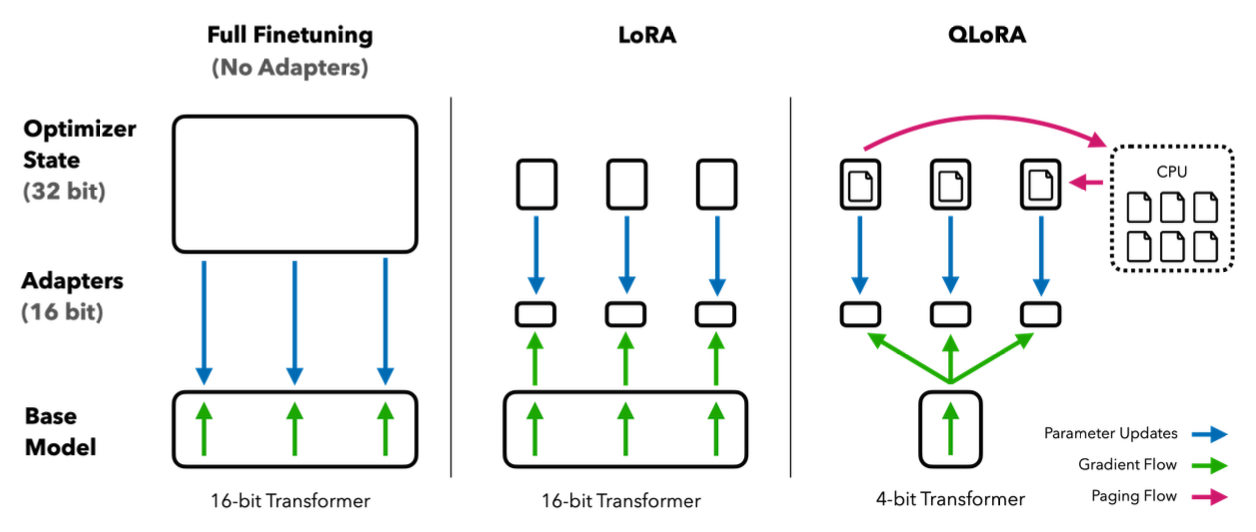

bitsandbytes是将模型量化为8位和4位的最简单选择。阈值。）

- 8位量化将fp16中的异常值与int8中的非异常值相乘，将非异常值转换回fp16，然后将它们相加以返回fp16中的权重。这减少了异常值对模型性能产生的降级效果。- 
4位量化进一步压缩了模型，并且通常与QLoRA一起用于微调量化LLM（低精度语言模型）。

（异常值是指大于某个阈值的隐藏状态值，这些值是以fp16进行计算的。虽然这些值通常服从正态分布（[-3.5, 3.5]），但对于大型模型来说，该分布可能会有很大差异（[-60, 6]或[6, 60]）。8位量化适用于约为5左右的数值，但超过此范围后将导致显著性能损失。一个好的默认阈值是6，但对于不稳定的模型（小型模型或微调）可能需要更低的阈值。）

## 在 Transformers 中使用参数量化

使用 Transformers 库的 model.from_pretrained()方法中的load_in_8bit或load_in_4bit参数，便可以对模型进行量化。只要模型支持使用Accelerate加载并包含torch.nn.Linear层，这几乎适用于任何模态的任何模型。

In [7]:
from transformers import AutoModelForCausalLM

model_id = "facebook/opt-2.7b"

model_4bit = AutoModelForCausalLM.from_pretrained(model_id,
                                                  device_map="auto",
                                                  load_in_4bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [8]:
model_4bit

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2560, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2560)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-31): 32 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
            (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
            (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
            (out_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
          

In [9]:
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model_4bit.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 2)  # 转换为 MiB

print(f"{memory_footprint_mib:.2f}MiB")

1457.52MiB


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id
                                         )
text = "Merry Christmas! I'm glad to"
inputs = tokenizer(text, return_tensors="pt").to(0)

out = model_4bit.generate(**inputs, max_new_tokens=64)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Merry Christmas! I'm glad to see you're still around.
I'm still around, just not posting as much. I'm still here, just not posting as much. I'm still here, just not posting as much. I'm still here, just not posting as much. I'm still here, just not posting as much. I'm


### 使用 NF4 精度加载模型

In [11]:
from transformers import BitsAndBytesConfig

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)

model_nf4 = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=nf4_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [12]:
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model_nf4.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 2)  # 转换为 MiB

print(f"{memory_footprint_mib:.2f}MiB")

1457.52MiB


### 使用双量化加载模型

In [13]:
double_quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
)

model_double_quant = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=double_quant_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [14]:
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model_double_quant.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 2)  # 转换为 MiB

print(f"{memory_footprint_mib:.2f}MiB")

1457.52MiB


### 使用 QLoRA 所有量化技术加载模型

In [15]:
import torch

qlora_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_qlora = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=qlora_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [16]:
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model_qlora.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 2)  # 转换为 MiB

print(f"{memory_footprint_mib:.2f}MiB")

1457.52MiB
